In [288]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from utils import *
import os
import joblib
from statsmodels.api import OLS, add_constant
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import itertools
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [289]:
def mse1(y_true, y_pred):
    if(y_true is None or y_pred is None):
        return 0
    
    return np.mean((y_true - y_pred)**2)

In [290]:
start_date = '2011-04-30'
end_date = '2016-04-30'

In [291]:
df_all = pd.read_csv('data/df_all.csv', dtype={'asset': str})
df_all['date'] = pd.to_datetime(df_all['date'])

df_all.drop(['Unnamed: 0'], axis=1, inplace=True)

df_all_pivot = df_all.pivot(index='date', columns='asset')

In [292]:
returns = pd.read_csv('data/returns.csv', index_col=0)
returns.index = pd.to_datetime(returns.index)
all_time_index = returns.index
all_time_index

DatetimeIndex(['2011-05-03', '2011-05-04', '2011-05-05', '2011-05-06',
               '2011-05-09', '2011-05-10', '2011-05-11', '2011-05-12',
               '2011-05-13', '2011-05-16',
               ...
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-24', '2023-04-25', '2023-04-26',
               '2023-04-27', '2023-04-28'],
              dtype='datetime64[ns]', name='date', length=2918, freq=None)

In [293]:
print("已经有的原始数据：")
df_all.columns

已经有的原始数据：


Index(['asset', 'date', 'open', 'close', 'high', 'low', 'volume', 'amount',
       'vwap', 'pctChg', 'turnover', 'benchmark_open', 'benchmark_close',
       'benchmark_high', 'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd',
       'epq', 'emq', 'sgq', 'alaq', 'pmq', 'cta', 'size', 'Rmrf', 'Smb', 'Hml',
       'rf', 'bm', 'ep'],
      dtype='object')

In [294]:
# 将returns数据和df_all_pivot数据合并

returns.columns = pd.MultiIndex.from_product([['returns'], returns.columns], names=['', 'asset'])

df_all_pivot = pd.concat([df_all_pivot, returns], axis=1)

print(df_all_pivot.columns.get_level_values(0).unique())

Index(['open', 'close', 'high', 'low', 'volume', 'amount', 'vwap', 'pctChg',
       'turnover', 'benchmark_open', 'benchmark_close', 'benchmark_high',
       'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd', 'epq', 'emq',
       'sgq', 'alaq', 'pmq', 'cta', 'size', 'Rmrf', 'Smb', 'Hml', 'rf', 'bm',
       'ep', 'returns'],
      dtype='object')


In [295]:
# 从因子数据中读取因子
alphaset = 'ourAlphas'
subset = '20110430'

alpha_names = ['alpha_CH3_Size','alpha_CH3_Size_NOT', 'alpha_CH3_turnover', 'alpha_CH3_turnover_NOT', 'alpha_CH3_Value', 'alpha_CH3_Value_NOT', 'alpha_Rmrf', 'alpha_Smb', 'alpha_Smb_NOT', 'alpha_Hml', 'alpha_Hml_NOT']

# 创建一个DataFrame，用于存储因子数据
alpha_df = pd.DataFrame(index=all_time_index, columns=alpha_names)

for alpha_name in alpha_names:
    alpha = pd.read_csv('alphas/{}/{}/{}.csv'.format(alphaset, subset, alpha_name))
    
    # 从因子数据中读取因子
    alpha = alpha.set_index('date')
    alpha.index = pd.to_datetime(alpha.index)

    # 只取一只股票的数据（因为计算出的因子只在时间维度上变化）
    alpha = alpha[alpha.columns[0]]
    
    alpha_df[alpha_name] = alpha
    

In [296]:
alpha_df.columns

Index(['alpha_CH3_Size', 'alpha_CH3_Size_NOT', 'alpha_CH3_turnover',
       'alpha_CH3_turnover_NOT', 'alpha_CH3_Value', 'alpha_CH3_Value_NOT',
       'alpha_Rmrf', 'alpha_Smb', 'alpha_Smb_NOT', 'alpha_Hml',
       'alpha_Hml_NOT'],
      dtype='object')

In [297]:
# 截取时间段
df_all_pivot = df_all_pivot.loc[start_date:end_date]
alpha_df = alpha_df.loc[start_date:end_date]

rf = df_all_pivot['rf'].iloc[:, 0]

df_all_pivot.index, alpha_df.index, rf

(DatetimeIndex(['2011-05-03', '2011-05-04', '2011-05-05', '2011-05-06',
                '2011-05-09', '2011-05-10', '2011-05-11', '2011-05-12',
                '2011-05-13', '2011-05-16',
                ...
                '2016-04-18', '2016-04-19', '2016-04-20', '2016-04-21',
                '2016-04-22', '2016-04-25', '2016-04-26', '2016-04-27',
                '2016-04-28', '2016-04-29'],
               dtype='datetime64[ns]', name='date', length=1216, freq=None),
 DatetimeIndex(['2011-05-03', '2011-05-04', '2011-05-05', '2011-05-06',
                '2011-05-09', '2011-05-10', '2011-05-11', '2011-05-12',
                '2011-05-13', '2011-05-16',
                ...
                '2016-04-18', '2016-04-19', '2016-04-20', '2016-04-21',
                '2016-04-22', '2016-04-25', '2016-04-26', '2016-04-27',
                '2016-04-28', '2016-04-29'],
               dtype='datetime64[ns]', name='date', length=1216, freq=None),
 date
 2011-05-03    0.025525
 2011-05-04    0.02516

In [298]:
def generate_Y(isFama=True, isweighted=True):
    if isFama:
        results = pd.read_csv(f'alphas/multialpha/alpha_portfolio_Fama_{isweighted}.csv')
    else:
        results = pd.read_csv(f'alphas/multialpha/alpha_portfolio_CH3_{isweighted}.csv')
    
    results['date'] = pd.to_datetime(results['date'])    
    results = results.set_index('date')
    
    
    return results

def generate_X(alpha_df, isFama=True, isweighted=True, isCH3=False):
    if isFama and isweighted:
        results = alpha_df[['alpha_Rmrf', 'alpha_Smb', 'alpha_Hml']]
    elif isFama and not isweighted:
        results = alpha_df[['alpha_Rmrf', 'alpha_Smb_NOT', 'alpha_Hml_NOT']]
    elif not isFama and isweighted:
        results = alpha_df[['alpha_Rmrf', 'alpha_CH3_Size', 'alpha_CH3_turnover', 'alpha_CH3_Value']]
        if isCH3:
            results = alpha_df[['alpha_Rmrf', 'alpha_CH3_Size', 'alpha_CH3_Value']]
    else:
        results = alpha_df[['alpha_Rmrf', 'alpha_CH3_Size_NOT', 'alpha_CH3_turnover_NOT', 'alpha_CH3_Value_NOT']]
        if isCH3:
            results = alpha_df[['alpha_Rmrf', 'alpha_CH3_Size_NOT', 'alpha_CH3_Value_NOT']]
        
    return results
        
def regression(isFama, isweighted, isCH3=False):
    
    Y = generate_Y(isFama=isFama, isweighted=isweighted)
    X = generate_X(alpha_df, isFama=isFama, isweighted=isweighted, isCH3=isCH3)

    Y = Y.loc[X.index]

    print(Y.shape, X.shape)

    Y = Y - rf.values.reshape(-1, 1)
    X = sm.add_constant(X)
    
    
    expected_returns = pd.DataFrame(index=Y.index, columns=Y.columns)
    
    results = []
    for col in tqdm(Y.columns):
        y = Y[col]
        x = X
        model = OLS(y, x, missing='drop').fit()
        results.append(model)
        expected_returns[col] = model.predict(x)
    
    # 计算平均expected returns, 输出最大的expected returns
    expected_returns_mean = expected_returns.mean(axis=0)
    
    print("最大的expected returns: ", expected_returns_mean.idxmax(), expected_returns_mean.max())
    
    return results, expected_returns

In [299]:
def summary_model(models, name):
    for result in models:
        if name in result.model.endog_names:
            print(result.summary())
            print("MSE: ", mse1(result.model.endog, result.predict(result.model.exog)))

## 画出两个分组的累积收益率

In [300]:
def plot_cumulative_returns(isFama, isweighted, title):
    
    Y = generate_Y(isFama=isFama, isweighted=isweighted)
    
    # 截取时间段
    Y = Y.loc[start_date:end_date]
    
    # 对Y的每个column计算累计收益率
    cumulative_returns = (1 + Y).cumprod(axis=0) - 1  # 计算累计收益率
    
    # 绘制图表
    plt.figure(figsize=(10, 6))
    for col in cumulative_returns.columns:
        plt.plot(cumulative_returns.index, cumulative_returns[col], label=col)
    
    # 添加标题和标签
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend(title='Groups')
    plt.grid(True)
    plt.tight_layout()
    
    # 显示图表
    plt.show()

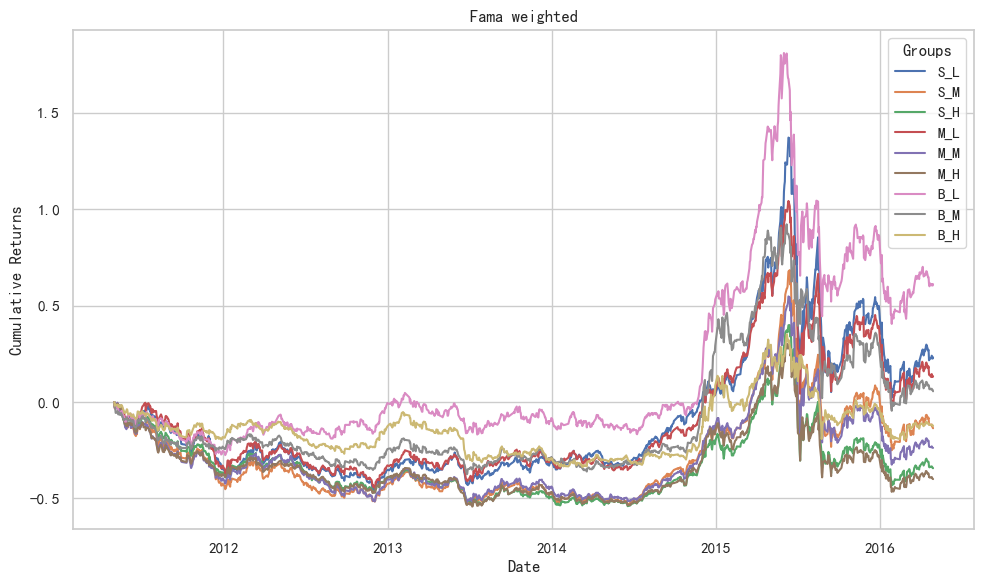

In [301]:
plot_cumulative_returns(isFama=True, isweighted=True, title='Fama weighted')

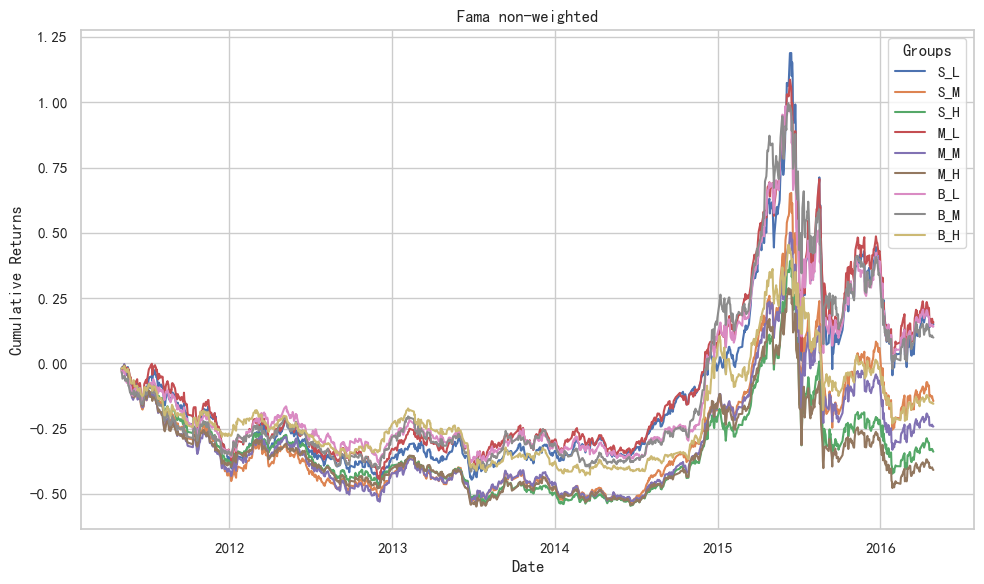

In [302]:
plot_cumulative_returns(isFama=True, isweighted=False, title='Fama non-weighted')

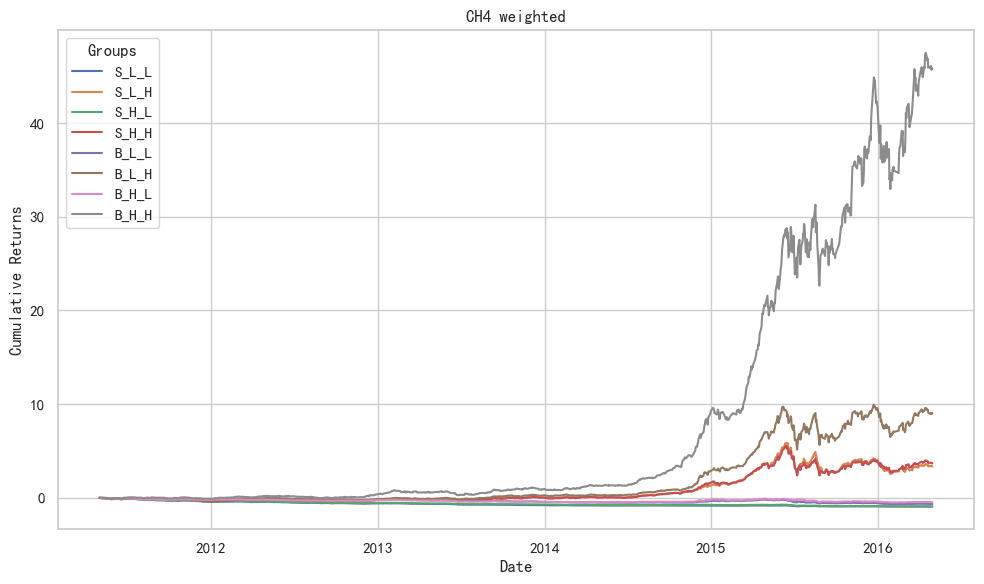

In [303]:
plot_cumulative_returns(isFama=False, isweighted=True, title='CH4 weighted')

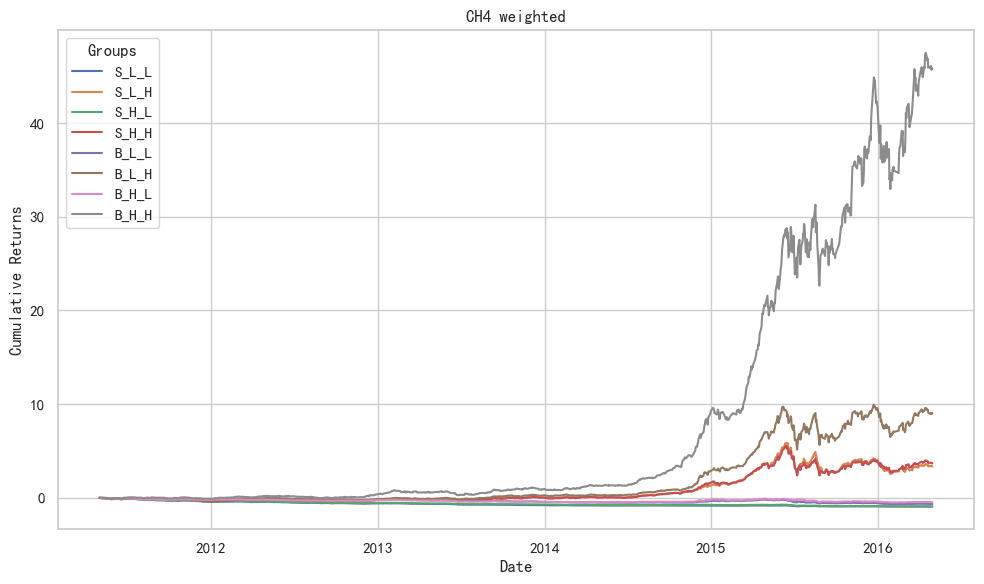

In [304]:
plot_cumulative_returns(isFama=False, isweighted=True, title='CH4 weighted')

## 三因子：FamaFrench

按市值、账面市值比分成9组，以每一组的市值加权收益率/直接加权收益率作为被解释变量，对应的Rmrf, Smb, Hml(+constant)作为解释变量

In [305]:
isweighted = True
isFama = True

fama_weighted_results, fama_weighted_return = regression(isFama, isweighted)
fama_nonweighted_results, fama_nonweighted_return = regression(isFama, not isweighted)

(1216, 9) (1216, 3)


100%|██████████| 9/9 [00:00<00:00, 945.04it/s]


最大的expected returns:  B_L -0.027062137248346513
(1216, 9) (1216, 3)


100%|██████████| 9/9 [00:00<00:00, 1056.32it/s]

最大的expected returns:  S_L -0.027242175857340168


In [306]:
summary_model(fama_weighted_results, 'B_L')


                            OLS Regression Results                            
Dep. Variable:                    B_L   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 1.025e+04
Date:                Sat, 28 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:40:24   Log-Likelihood:                 4848.2
No. Observations:                1185   AIC:                            -9688.
Df Residuals:                    1181   BIC:                            -9668.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -2.462      0.0

In [307]:
summary_model(fama_nonweighted_results, 'S_L')

                            OLS Regression Results                            
Dep. Variable:                    S_L   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 1.022e+04
Date:                Sat, 28 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:40:24   Log-Likelihood:                 4658.8
No. Observations:                1185   AIC:                            -9310.
Df Residuals:                    1181   BIC:                            -9289.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.000      3.601

## 四因子：CH4

按市值、账面市值比、换手率分成8组(2 * 2 * 2)，以每一组的市值加权收益率/直接加权收益率作为被解释变量，对应的CH3, CH3_Size, CH3_turnover(+constant)作为解释变量

In [308]:
isweighted = True
isFama = False

CH4_weighted_results, CH4_weighted_return = regression(isFama, isweighted)
CH4_nonweighted_results, CH4_nonweighted_return = regression(isFama, not isweighted)

(1216, 8) (1216, 4)


100%|██████████| 8/8 [00:00<00:00, 725.03it/s]


最大的expected returns:  B_H_H -0.021487137314519116
(1216, 8) (1216, 4)


100%|██████████| 8/8 [00:00<00:00, 569.80it/s]

最大的expected returns:  B_H_H -0.02202786349753826


In [309]:
summary_model(CH4_weighted_results, 'B_H_H')

                            OLS Regression Results                            
Dep. Variable:                  B_H_H   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1317.
Date:                Sat, 28 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:40:24   Log-Likelihood:                 2428.2
No. Observations:                 761   AIC:                            -4846.
Df Residuals:                     756   BIC:                            -4823.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0098      0

In [310]:
summary_model(CH4_nonweighted_results, 'B_H_H')

                            OLS Regression Results                            
Dep. Variable:                  B_H_H   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1702.
Date:                Sat, 28 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:40:24   Log-Likelihood:                 2535.8
No. Observations:                 761   AIC:                            -5062.
Df Residuals:                     756   BIC:                            -5038.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

## 三因子:CH3

分组方法同上

In [311]:
isweighted = True
isFama = False
isCH3 = True

CH3_weighted_results, CH3_weighted_return = regression(isFama, isweighted, isCH3)
CH3_nonweighted_results, CH3_nonweighted_return = regression(isFama, not isweighted, isCH3)

(1216, 8) (1216, 3)


100%|██████████| 8/8 [00:00<00:00, 761.16it/s]


最大的expected returns:  B_H_H -0.02423045372327879
(1216, 8) (1216, 3)


100%|██████████| 8/8 [00:00<00:00, 1214.16it/s]

最大的expected returns:  B_H_H -0.02473487441184184


In [312]:
summary_model(CH3_weighted_results, 'B_H_H')

                            OLS Regression Results                            
Dep. Variable:                  B_H_H   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     2635.
Date:                Sat, 28 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:40:24   Log-Likelihood:                 3866.6
No. Observations:                1185   AIC:                            -7725.
Df Residuals:                    1181   BIC:                            -7705.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0100      0.000     

In [313]:
summary_model(CH3_nonweighted_results, 'B_H_H')

                            OLS Regression Results                            
Dep. Variable:                  B_H_H   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     3433.
Date:                Sat, 28 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:40:24   Log-Likelihood:                 4042.3
No. Observations:                1185   AIC:                            -8077.
Df Residuals:                    1181   BIC:                            -8056.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0081    